# Configure font

In [1]:
# Configure Arial as the default font in all figures

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


arial_font_path = '/PATH/TO/ARIAL/FONT/arial.ttf'

fm.fontManager.addfont(arial_font_path)

plt.rcParams['font.family'] = 'Arial'

# Path to Zenodo files folder

In [2]:
path = 'PATH/TO/ZENODO/FILES/FOLDER'

# Figure 2

## Panel C

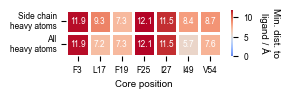

In [3]:
#Build contact map

import Bio.PDB
import numpy as np
from Bio.PDB import PDBParser, PDBIO, Select
from Bio.SeqUtils import seq1
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import pandas as pd
import seaborn as sns
from pathlib import Path


def calc_residue_dist(residue_one, residue_two) :
    """Returns the minimum distance between any atom in two residues (except for backbone C, O and N)"""
    if 'CB' in residue_one and 'CB' in residue_two:
        all_residue_one_distances=[]
        for atom_one in residue_one:
            atom_one_type=str(atom_one)
            atom_one_type=atom_one_type[6:-1]
            if atom_one_type[0] != 'H' and atom_one_type != 'N' and atom_one_type != 'C' and atom_one_type != 'O' and atom_one_type != 'CA':
                all_atom_one_distances=[]
                for atom_two in residue_two:
                    atom_two_type=str(atom_two)
                    atom_two_type=atom_two_type[6:-1]
                    if atom_two_type[0] != 'H' and atom_two_type != 'N' and atom_two_type != 'C' and atom_two_type != 'O' and atom_two_type != 'CA':
                        diff_vector = atom_one.coord - atom_two.coord
                        all_atom_one_distances.append(np.sqrt(np.sum(diff_vector * diff_vector)))
                all_residue_one_distances.append(min(all_atom_one_distances))
        return min(all_residue_one_distances)

def calc_residue_dist_allatom(residue_one, residue_two) :
    """Returns the minimum distance between any atom in two residues"""
    all_residue_one_distances=[]
    for atom_one in residue_one:
        atom_one_type=str(atom_one)
        atom_one_type=atom_one_type[6]
        if atom_one_type != 'H':
            all_atom_one_distances=[]
            for atom_two in residue_two:
                atom_two_type=str(atom_two)
                atom_two_type=atom_two_type[6]
                if atom_two_type != 'H':
                    #diff_vector = atom_one.coord - atom_two.coord
                    #all_atom_one_distances.append(np.sqrt(np.sum(diff_vector * diff_vector)))
                    all_atom_one_distances.append(np.linalg.norm(atom_one.coord - atom_two.coord))
            all_residue_one_distances.append(min(all_atom_one_distances))
    return min(all_residue_one_distances)

def calc_dist_matrix(chain_one, chain_two) :
    """Returns a matrix of side-chain distances between two chains"""
    answer = np.zeros((len(chain_one), len(chain_two)), float)
    for row, residue_one in enumerate(chain_one) :
        for col, residue_two in enumerate(chain_two) :
            answer[row, col] = calc_residue_dist(residue_one, residue_two)
    return answer

def calc_dist_matrix_allatom(chain_one, chain_two) :
    """Returns a matrix of minimum distances between two chains, considering all heavy atoms"""
    answer = np.zeros((len(chain_one), len(chain_two)), float)
    for row, residue_one in enumerate(chain_one) :
        for col, residue_two in enumerate(chain_two) :
            answer[row, col] = calc_residue_dist_allatom(residue_one, residue_two)
    return answer


pdb_code='FYN_PRD1super'

pdb_path = str(Path(path).expanduser())
pdb_filename = pdb_path+'/Fig7/' + pdb_code + '.pdb'

structure = Bio.PDB.PDBParser().get_structure(pdb_code, pdb_filename)
model = structure[0]

chain = 'A'

dist_matrix = calc_dist_matrix(model['A'], model['B'])
contact_map = dist_matrix < 5.0

dist_matrix_allatom = calc_dist_matrix_allatom(model['A'], model['B'])
contact_map_allatom = dist_matrix_allatom < 5.0

FYN_core_pos=[2, 16, 18, 24, 26, 48, 53]
chains = {chain.id:seq1(''.join(residue.resname for residue in chain)) for chain in structure.get_chains()} #Read amino acid sequence
seq = chains[chain]
seq=list(seq)
FYN_wt=''.join(seq)

FYN_core_positions = [FYN_wt[i]+str(i+1) for i in FYN_core_pos]
core_distances=pd.DataFrame()
for distance_matrix in enumerate([dist_matrix, dist_matrix_allatom]):
    
    allatom_dist_df = pd.DataFrame(data=distance_matrix[1],
                                  index=[FYN_wt[i] + str(i+1) for i in np.arange(0,len(model['A']),1)],
                                  columns=np.arange(1,len(model['B'])+1,1))
    allatom_dist_df['min_dist_to_ligand'] = allatom_dist_df.min(axis=1)
    
    core_distances[distance_matrix[0]]=allatom_dist_df[allatom_dist_df.index.isin(FYN_core_positions)]['min_dist_to_ligand']
core_distances=core_distances.rename(columns={0:'Side chain\nheavy atoms',1:'All\nheavy atoms'})

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2.5,0.6))
sns.heatmap(core_distances.T, annot=True, fmt=".1f", cmap='coolwarm', vmin=0,ax=ax, linewidths=2, annot_kws={'color':'white', 'font':'Arial', 'size':6}, center=5)
ax.figure.axes[-1].set_ylabel('Min. dist. to\nligand / Å', rotation=270, labelpad=20, font='Arial', fontsize=7)
ax.figure.axes[-1].set_yticks(ticks=np.arange(0,15,5),labels=np.arange(0,15,5), font='Arial', fontsize=6)
plt.xticks(font='Arial',fontsize=6, rotation=0)
plt.yticks(font='Arial',fontsize=6, rotation=0)
plt.xlabel('Core position', fontsize=7)
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('FYN_PDR1super_mindistsheatmap.svg', dpi=300, transparent=True, bbox_inches='tight')

In [4]:
core_distances.to_csv(path+'Fig7/FYN_core_distances.txt',sep='\t')

## Panel D

In [5]:
bindingvars = pd.read_csv(path+"Fig7/FYN_bPCA_fitness_replicates.txt",
                         sep='\t', lineterminator='\n', low_memory=False)

bindingvars = bindingvars.sort_values('fitness', ascending=False)

FYN_core_seq = 'FLFFIIV'
FYN_core_pos = [2,16,18,24,26,48,53]
bindingvars["core"] = pd.Series(dtype="object")
for index, row in bindingvars.iterrows():
    core=[]
    for i in FYN_core_pos:
        core.append(row.aa_seq[i])
    bindingvars.at[index,'core'] = ''.join(core)
    
    if core == FYN_core_seq:
        bindingvars.at[index, 'Nham_aa'] = 0
    else:
        bindingvars.at[index, 'Nham_aa'] = sum(1 for a,b in zip(FYN_core_seq, core) if a!=b)

bindingvars

,nt_seq,aa_seq,Nham_nt,Nham_aa,Nmut_codons,WT,indel,STOP,STOP_readthrough,count_e1_s0,...,sigma,growthrate1,growthrate1_sigma,growthrate2,growthrate2_sigma,growthrate3,growthrate3_sigma,growthrate,growthrate_sigma,core
21034,NaN,TLMVALYDYEARTEDDLSLHKGEKFQILNSSEGDWWEARSLTTGET...,NaN,2,NaN,NaN,False,False,False,178,...,0.038010,0.208139,0.003512,0.215109,0.006757,0.224259,0.011738,0.214630,0.003153,MLLFIIV
20463,NaN,TLMVALYDYEARTEDDLSFHKGEKFQILNSSEGDWWEARSLTTGET...,NaN,3,NaN,NaN,False,False,False,276,...,0.032730,0.208687,0.003046,0.210929,0.005537,0.221097,0.010578,0.214087,0.002715,MLFFIVL
20459,NaN,TLMVALYDYEARTEDDLSFHKGEKFQILNSSEGDWWEARSLTTGET...,NaN,3,NaN,NaN,False,False,False,194,...,0.036294,0.209165,0.003409,0.206391,0.006001,0.217822,0.011587,0.213067,0.003011,MLFFIVI
8000,NaN,TLIVALYDYEARTEDDLSFHKGEKFQVLNSSEGDWWEARSLTTGET...,NaN,2,NaN,NaN,False,False,False,132,...,0.040456,0.208705,0.003915,0.204053,0.006508,0.219284,0.011550,0.211803,0.003356,ILFFVIV
20558,NaN,TLMVALYDYEARTEDDLSFHKGEKLQILNSSEGDWWEARSLTTGET...,NaN,2,NaN,NaN,False,False,False,222,...,0.034647,0.207458,0.003261,0.205464,0.005780,0.219571,0.010728,0.211672,0.002874,MLFLIIV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1325,NaN,TLIVALYDYEARTEDDMSMHKGEKMQMLNSSEGDWWEARSLTTGET...,NaN,6,NaN,NaN,False,False,False,62,...,0.423567,-0.055777,0.048741,-0.040584,0.044214,NaN,NaN,-0.059852,0.035138,IMMMMFV
4017,NaN,TLIVALYDYEARTEDDVSLHKGEKIQLLNSSEGDWWEARSLTTGET...,NaN,7,NaN,NaN,False,False,False,48,...,0.422266,-0.047600,0.048813,-0.048727,0.043916,NaN,NaN,-0.060711,0.035030,IVLILMI
4428,NaN,TLIVALYDYEARTEDDVSIHKGEKMQVLNSSEGDWWEARSLTTGET...,NaN,7,NaN,NaN,False,False,False,51,...,0.565321,NaN,NaN,-0.051772,0.043823,NaN,NaN,-0.064032,0.046898,IVIMVMF
42681,NaN,TLLVALYDYEARTEDDFSVHKGEKVQLLNSSEGDWWEARSLTTGET...,NaN,7,NaN,NaN,False,False,False,110,...,0.350424,-0.051950,0.034515,-0.059477,0.043622,NaN,NaN,-0.068015,0.029070,LFVVLMI


In [6]:
from seaborn import kdeplot
import numpy as np
import matplotlib.pyplot as plt

bindingvars_scaled = bindingvars.copy()

def normalize(values, bounds):
    return [bounds['desired']['lower'] + (x - bounds['actual']['lower']) * (bounds['desired']['upper'] - bounds['desired']['lower']) / (bounds['actual']['upper'] - bounds['actual']['lower']) for x in values]

def normalize_errors(values, bounds):
    return [x * (bounds['desired']['upper'] - bounds['desired']['lower']) / (bounds['actual']['upper'] - bounds['actual']['lower']) for x in values]

arbitraryWT='FLFFVIV'

fig, ax = plt.subplots()

my_kde = kdeplot(data=bindingvars, x='fitness', ax=ax)

lines = my_kde.get_lines()
plt.close()
for line in lines:
    x, y = line.get_data()
    mode=(x[np.argmax(y)])
    ax.axvline(x[np.argmax(y)], ls='--')

bindingvars_scaled['fitness']=normalize(list(bindingvars_scaled['fitness']),{'actual': {'lower': mode, 'upper': bindingvars_scaled.loc[bindingvars_scaled['core']==arbitraryWT]['fitness'].iloc[0]}, 'desired': {'lower': -1, 'upper': 0}})
bindingvars_scaled['sigma']=normalize_errors(list(bindingvars_scaled['sigma']),{'actual': {'lower': mode, 'upper': bindingvars_scaled.loc[bindingvars_scaled['core']==arbitraryWT]['fitness'].iloc[0]}, 'desired': {'lower': -1, 'upper': 0}})
bindingvars_scaled['fitness1_uncorr']=normalize(list(bindingvars_scaled['fitness1_uncorr']),{'actual': {'lower': mode, 'upper': bindingvars_scaled.loc[bindingvars_scaled['core']==arbitraryWT]['fitness1_uncorr'].iloc[0]}, 'desired': {'lower': -1, 'upper': 0}})
bindingvars_scaled['sigma1_uncorr']=normalize_errors(list(bindingvars_scaled['sigma1_uncorr']),{'actual': {'lower': mode, 'upper': bindingvars_scaled.loc[bindingvars_scaled['core']==arbitraryWT]['fitness'].iloc[0]}, 'desired': {'lower': -1, 'upper': 0}})
bindingvars_scaled['fitness2_uncorr']=normalize(list(bindingvars_scaled['fitness2_uncorr']),{'actual': {'lower': mode, 'upper': bindingvars_scaled.loc[bindingvars_scaled['core']==arbitraryWT]['fitness2_uncorr'].iloc[0]}, 'desired': {'lower': -1, 'upper': 0}})
bindingvars_scaled['sigma2_uncorr']=normalize_errors(list(bindingvars_scaled['sigma2_uncorr']),{'actual': {'lower': mode, 'upper': bindingvars_scaled.loc[bindingvars_scaled['core']==arbitraryWT]['fitness'].iloc[0]}, 'desired': {'lower': -1, 'upper': 0}})
bindingvars_scaled['fitness3_uncorr']=normalize(list(bindingvars_scaled['fitness3_uncorr']),{'actual': {'lower': mode, 'upper': bindingvars_scaled.loc[bindingvars_scaled['core']==arbitraryWT]['fitness3_uncorr'].iloc[0]}, 'desired': {'lower': -1, 'upper': 0}})
bindingvars_scaled['sigma3_uncorr']=normalize_errors(list(bindingvars_scaled['sigma3_uncorr']),{'actual': {'lower': mode, 'upper': bindingvars_scaled.loc[bindingvars_scaled['core']==arbitraryWT]['fitness'].iloc[0]}, 'desired': {'lower': -1, 'upper': 0}})

fig, ax = plt.subplots()

my_kde = kdeplot(data=bindingvars_scaled, x='fitness', ax=ax)

lines = my_kde.get_lines()

for line in lines:
    x, y = line.get_data()

plt.close()

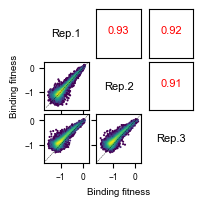

In [7]:
from scipy.stats import pearsonr
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.family'] = 'Arial'

warnings.filterwarnings('ignore')

def reg_coef(x,y,label=None,color=None,hue=None,**kwargs):
    ax = plt.gca()
    r,p = pearsonr(x,y)
    ax.annotate('{:.2f}'.format(r), xy=(0.5,0.5), xycoords='axes fraction', ha='center', size = 8, color='red')
    ax.tick_params(right=False, top=False, left=False, bottom=False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    #ax.tick_params(axis='both', which='major', labelsize=14)
def replicate(x,**kwargs):
    ax = plt.gca()
    ax.text(.5,.5,'Rep.'+x.name[7:8],size=8,ha='center',va='center', transform=ax.transAxes)
    ax.set_axis_off()
def hexbin(x, y, color, **kwargs): #https://stackoverflow.com/questions/40495093/hexbin-plot-in-pairgrid-with-seaborn
    ax = plt.gca()
    cmap = sns.color_palette('viridis', as_cmap=True)
    ax.hexbin(x, y, bins='log',gridsize=50, cmap=cmap, extent=[min(x), max(x), min(y), max(y)], **kwargs, rasterized=True)
    lims = np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])
    plt.plot(lims, lims, '--', color='k', linewidth=0.3)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.set_ylim(-1.75,0.25)
    ax.set_xlim(-1.75,0.25)
    ax.set_xticks(np.arange(-1,1,1))
    ax.set_yticks(np.arange(-1,1,1))
    ax.tick_params(axis='both', which='major', labelsize=6)

g = sns.PairGrid(bindingvars_scaled[['fitness1_uncorr', 'fitness2_uncorr', 'fitness3_uncorr']].dropna())
g.map_upper(reg_coef, hue=None)
g.map_diag(replicate)
g.map_lower(hexbin)
g.fig.set_size_inches(1.7,1.7)

for i in range(3):
    g.axes[i, i].set_visible(False)

for ax in g.axes.flatten():
    if ax.get_xlabel() != '':
        if str(ax.get_xlabel().split('_')[0][-1]) == '1' or str(ax.get_xlabel().split('_')[0][-1]) == '3':
            ax.set_xlabel('')
        else:
            ax.set_xlabel('Binding fitness', fontsize=7)
    if ax.get_ylabel() != '':
        if str(ax.get_ylabel().split('_')[0][-1]) == '1' or str(ax.get_ylabel().split('_')[0][-1]) == '3':
            ax.set_ylabel('')
        else:
            ax.set_ylabel('Binding fitness', fontsize=7)
plt.rcParams['svg.fonttype'] = 'none'
#aplt.savefig('FYN_binding_Fitness_correl.svg', dpi=300, transparent=True, bbox_inches='tight')

## Panel E

In [8]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)

    return newcmap

iterator_cmap=0

In [9]:
from itertools import product
from tqdm import tqdm

DTS = ['F','L','I','M','V']
a=list(product(DTS,repeat=7))

dod={}
for variant in tqdm(a, total=len(a)):
    iterator=0
    positerator=0
    singles=[]
    for i in product(variant,DTS):
        mutant = ''.join(''.join(variant[:positerator])+str(i[1])+''.join(variant[positerator+1:]))
        if (iterator/5).is_integer() == True and iterator !=0:
            positerator+=1
        iterator+=1
        if mutant != ''.join(variant):
            singles.append(mutant)
    dod[''.join(variant)]=singles

100%|██████████| 78125/78125 [00:01<00:00, 41932.72it/s]


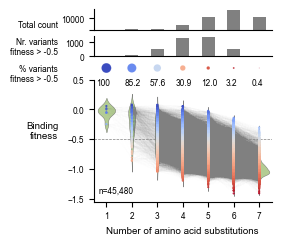

In [10]:
import seaborn as sns
import networkx as nx
from itertools import count
from seaborn import kdeplot
from itertools import groupby
import matplotlib
import numpy as np

protein='P06241'

protein_variants_scaled=bindingvars_scaled#.loc[bindingvars_scaled['WT']!=True].copy()
lowest_nham=int(protein_variants_scaled.sort_values('Nham_aa', ascending=True).iloc[0]['Nham_aa'])
lines = kdeplot(data=protein_variants_scaled, x='fitness', ax=ax).get_lines()
    
for line in lines:
    x, y = line.get_data()
    mode=x[np.argmax(y)]

G = nx.from_dict_of_lists(dod)
G_val = nx.from_dict_of_lists(dod)

pos={}
for index, row in protein_variants_scaled.iterrows():
    pos[row.core] = (row.Nham_aa-1, row.fitness)
    
validated = ['FLFFVIV', 'MLFFIVL', 'MFFFVIL', 'MMFLIVF', 'LMFMLVF', 'LMVLLVL']
pos_val={}
for index, row in protein_variants_scaled[protein_variants_scaled['core'].isin(validated)].iterrows():
    pos_val[row.core] = (row.Nham_aa-1, row.fitness)

fig, (ax0,axviable,ax1,ax2) = plt.subplots(4,1,gridspec_kw={'height_ratios':[2,2,1,12],'hspace': 0.15},figsize=(2.3,2.5))#,sharex=ax1)


fig=sns.violinplot(x="Nham_aa", y="fitness", data=protein_variants_scaled, inner=None, ax=ax2, color='#B4D689', linewidth=0.3)
plt.axhline(y=-0.5, linestyle='--', color='gray', linewidth=0.5)

remove=[i for i in dod.keys() if i not in pos.keys()]
remove_val=[i for i in dod.keys() if i not in pos_val.keys()]

G.remove_nodes_from(remove)
G_val.remove_nodes_from(remove_val)

fitness_values=[]
for i in pos:
    fitness_values.append(pos[i][1])
groups = []
for _, g in groupby(fitness_values, lambda x: (x-1)//0.05):
    groups.append(list(g))      # Store group iterator as a list

fitness_attr={}
for node in G.nodes:
    iterator=0
    for bin in groups:
        if pos[node][1] in bin:
            fitness_attr[node]=iterator
            break
        iterator+=1

nx.set_node_attributes(G, fitness_attr, 'fitness')
groups = set(nx.get_node_attributes(G,'fitness').values())
mapping = dict(zip(sorted(groups),count()))
nodes = G.nodes()
colors = [mapping[G.nodes[n]['fitness']] for n in nodes]

total_viable=0
nham_viability=pd.DataFrame(columns=['Number_of_variants','Fraction_50pc_folded'])
for nham in range(1,8,1):
    nham_viability.at[nham,'protein']=protein
    nham_viability.at[nham,'nham']=nham
    nham_viability.at[nham,'Number_of_variants']=len(protein_variants_scaled.loc[protein_variants_scaled['Nham_aa']==nham])
    nham_viability.at[nham,'Fraction_50pc_folded']=round(100*(len(protein_variants_scaled.loc[protein_variants_scaled['Nham_aa']==nham].loc[protein_variants_scaled['fitness']>=-0.5].index)/len(protein_variants_scaled.loc[protein_variants_scaled['Nham_aa']==nham])),1)
    nham_viability.at[nham,'Number_of_50pc_folded_variants']=len(protein_variants_scaled.loc[protein_variants_scaled['Nham_aa']==nham].loc[protein_variants_scaled['fitness']>=-0.5].index)
    nham_viability.at[nham,'Fraction_75pc_folded']=round(100*(len(protein_variants_scaled.loc[protein_variants_scaled['Nham_aa']==nham].loc[protein_variants_scaled['fitness']>=-0.25].index)/len(protein_variants_scaled.loc[protein_variants_scaled['Nham_aa']==nham])),1)
    nham_viability.at[nham,'Number_of_75pc_folded_variants']=len(protein_variants_scaled.loc[protein_variants_scaled['Nham_aa']==nham].loc[protein_variants_scaled['fitness']>=-0.25].index)
    nham_viability.at[nham,'Fraction_90pc_folded']=round(100*(len(protein_variants_scaled.loc[protein_variants_scaled['Nham_aa']==nham].loc[protein_variants_scaled['fitness']>=-0.1].index)/len(protein_variants_scaled.loc[protein_variants_scaled['Nham_aa']==nham])),1)
    nham_viability.at[nham,'Number_of_90pc_folded_variants']=len(protein_variants_scaled.loc[protein_variants_scaled['Nham_aa']==nham].loc[protein_variants_scaled['fitness']>=-0.1].index)
    total_viable=total_viable+len(protein_variants_scaled.loc[protein_variants_scaled['Nham_aa']==nham].loc[protein_variants_scaled['fitness']>=-0.5].index)
for index, row in nham_viability.iterrows():
    nham_viability.at[index,'Fraction_of_total_50pc_viable_variants']= round(100*row['Number_of_50pc_folded_variants']/total_viable,1)

total_core_viabilities = pd.DataFrame(columns=['protein', 'variants_above_01', 'variants_above_025', 'variants_above_05', 'variants_below_05'])
total_core_viabilities.at[protein,'variants_above_01']=len(protein_variants_scaled.loc[protein_variants_scaled['fitness']>=-0.1].index)/len(protein_variants_scaled.index)*5**7
total_core_viabilities.at[protein,'variants_above_025']=len(protein_variants_scaled.loc[protein_variants_scaled['fitness']>=-0.25].index)/len(protein_variants_scaled.index)*5**7
total_core_viabilities.at[protein,'variants_below_05']=5**7-len(protein_variants_scaled.loc[protein_variants_scaled['fitness']>=-0.5].index)/len(protein_variants_scaled.index)*5**7
total_core_viabilities.at[protein,'variants_above_05']=len(protein_variants_scaled.loc[protein_variants_scaled['fitness']>=-0.5].index)/len(protein_variants_scaled.index)*5**7


    
orig_cmap = plt.cm.coolwarm
iterator_cmap+=1
midpoint=(-0.5 - np.min(protein_variants_scaled['fitness']))/ (np.max(protein_variants_scaled['fitness']) - np.min(protein_variants_scaled['fitness']))
shifted_cmap = shiftedColorMap(orig_cmap, midpoint=1-midpoint, name='shifted'+str(iterator_cmap))
    
nx.draw_networkx(G, pos=pos, with_labels=False, node_size=0, ax=ax2, edge_color='gray', width=0.002)
nodes=nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=colors, node_size=0.3, cmap=shifted_cmap)
#nx.draw_networkx(G_val, pos=pos_val, with_labels=False, node_size=10, ax=ax2, width=0, node_shape=matplotlib.markers.MarkerStyle(marker='o', fillstyle='none'), node_color='k')
ax2.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax2.set_xlabel('Number of amino acid substitutions', fontsize=7)
ax2.set_ylabel("Binding\nfitness", fontsize=7,rotation='horizontal', ha='right')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.tick_params(axis='both', which='major', labelsize=6)

nham_viability['Fraction_50pc_folded'] = pd.to_numeric(nham_viability['Fraction_50pc_folded'], errors='coerce')
sns.scatterplot(x=[i-lowest_nham for i in nham_viability['nham']],y=[0]*len(nham_viability.index), hue=nham_viability['Fraction_50pc_folded'],palette='coolwarm_r', s=nham_viability['Fraction_50pc_folded']*0.5, legend=False,ax=ax1)
ax1.spines[['top','right','left','bottom']].set_visible(False)
ax1.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False,top=False, right=False)
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
for index, row in nham_viability.iterrows():
    if row.Fraction_50pc_folded == 100.0:
        ax2.annotate(100, (row.nham-1.4,0.4), fontsize=6, color='black')
    else:
        ax2.annotate(row.Fraction_50pc_folded, (row.nham-1.3,0.4), fontsize=6, color='black')
ax1.set_ylabel('% variants\nfitness > -0.5',fontsize=6,rotation='horizontal', ha='right')
        
ax2.annotate('n='+f"{len(protein_variants_scaled):,}", (-0.3,-1.4), fontsize=6)
plt.subplots_adjust(hspace=0.05)

nham_viability['Number_of_variants'].plot.bar(ax=ax0,fontsize=6,color='gray')
ax0.spines[['top','right']].set_visible(False)
ax0.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax0.set_ylabel('Total count',fontsize=6, rotation='horizontal', ha='right')
labels = ax0.get_yticklabels()
labels[0] = ""
ax0.set_yticklabels(labels)

nham_viability['Number_of_50pc_folded_variants'].plot.bar(ax=axviable,fontsize=6,color='gray')
axviable.spines[['top','right']].set_visible(False)
axviable.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
axviable.set_ylabel('Nr. variants\nfitness > -0.5',fontsize=6,rotation='horizontal', ha='right')

ax0.get_yaxis().set_label_coords(-0.2,0)
axviable.get_yaxis().set_label_coords(-0.2,0)
ax1.get_yaxis().set_label_coords(-0.2,-1)
ax2.get_yaxis().set_label_coords(-0.2,0.5)

plt.ylim(-1.55,0.5)
plt.xlim(-0.5,6.5)
ax1.set_xlim(ax2.get_xlim())
ax0.set_xlim(ax2.get_xlim())
axviable.set_xlim(ax2.get_xlim())
plt.show()

## Panel F

In [11]:
# Load data

import pandas as pd
from Bio.Seq import Seq

stabilityvars = pd.read_csv(path+"Fig2/Sparse_DTS_Cores_fitness_replicates.txt",
                         sep='\t', lineterminator='\n')

stabilityvars = stabilityvars.sort_values('fitness', ascending = False)

# De-multiplex each protein's variants

ID_dict =  {'MT' : 'P0A9X9',
           'KT' : 'P01053',
           'TL' : 'P06241'}

for index, row in stabilityvars.iterrows():
    try:
        stabilityvars.at[index,'Protein']=ID_dict[row.aa_seq[:2]]
    except KeyError:
        continue

stabilityvars = stabilityvars.loc[stabilityvars['Protein']=='P06241'].copy()

# Find core sequences

cores = {'P06241' : [2,16,18,24,26,48,53]}

for index, row in stabilityvars.iterrows():
    core=[]
    for i in cores[row.Protein]:
        core.append(row.aa_seq[i])
    stabilityvars.at[index,'core'] = ''.join(core)

# Define WT cores

proteins = {'P06241': 'FYN-SH3'}

P06241 = 'ACGCTTTTCGTTGCATTGTATGATTATGAAGCAAGAACTGAAGATGATTTGTCTTTCCATAAAGGTGAAAAATTCCAAATCTTGAATTCTTCTGAAGGTGATTGGTGGGAAGCAAGATCTTTGACTACTGGTGAAACTGGTTATATCCCATCTAACTATGTCGCGCCTGTG'

prots=[P06241]

wt_cores = {}
for (prot_seq, prot_nam) in zip(prots, proteins.keys()):
    aa_seq=str(Seq(prot_seq).translate())
    wt_core=[]
    for i in cores[prot_nam]:
        wt_core.append(aa_seq[i])
    wt_cores[prot_nam]= ''.join(wt_core)

# Find Hamming distance to WT

for index, row in stabilityvars.iterrows():
    wt = wt_cores[row.Protein]
    stabilityvars.at[index, 'wt_core']=wt
    if row.core == wt:
        stabilityvars.at[index, 'Nham_aa'] = 0
    else:
        stabilityvars.at[index, 'Nham_aa'] = sum(1 for a,b in zip(wt, row.core) if a!=b)

stabilityvars

,nt_seq,aa_seq,Nham_nt,Nham_aa,Nmut_codons,WT,indel,STOP,STOP_readthrough,count_e1_s0,...,sigma,growthrate1,growthrate1_sigma,growthrate2,growthrate2_sigma,growthrate,growthrate_sigma,Protein,core,wt_core
9873,NaN,TLMVALYDYEARTEDDLSLHKGEKLQVLNSSEGDWWEARSLTTGET...,NaN,6.0,NaN,NaN,True,False,False,50,...,0.141862,0.239689,0.030180,0.226946,0.009375,0.232834,0.009311,P06241,MLLLVVL,FLFFIIV
9771,NaN,TLMVALYDYEARTEDDLSFHKGEKLQILNSSEGDWWEARSLTTGET...,NaN,4.0,NaN,NaN,True,False,False,36,...,0.156208,0.220078,0.035262,0.221325,0.010256,0.225696,0.010252,P06241,MLFLIVI,FLFFIIV
8439,NaN,TLMVALYDYEARTEDDMSFHKGEKLQILNSSEGDWWEARSLTTGET...,NaN,5.0,NaN,NaN,True,False,False,224,...,0.121382,0.221958,0.015723,0.211651,0.008968,0.217223,0.007966,P06241,MMFLIVF,FLFFIIV
13622,NaN,TLFVALYDYEARTEDDMSLHKGEKIQVLNSSEGDWWEARSLTTGET...,NaN,6.0,NaN,NaN,True,False,False,64,...,0.150420,0.186441,0.026924,0.215573,0.010191,0.215302,0.009872,P06241,FMLIVVL,FLFFIIV
9382,NaN,TLMVALYDYEARTEDDFSFHKGEKFQVLNSSEGDWWEARSLTTGET...,NaN,4.0,NaN,NaN,True,False,False,67,...,0.138986,0.211585,0.026351,0.206176,0.009328,0.210479,0.009122,P06241,MFFFVIL,FLFFIIV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10069,NaN,TLVVALYDYEARTEDDISLHKGEKIQLLNSSEGDWWEARSLTTGET...,NaN,7.0,NaN,NaN,True,False,False,57,...,0.688682,NaN,NaN,-0.060774,0.043048,-0.069658,0.045199,P06241,VILILLL,FLFFIIV
10635,NaN,TLVVALYDYEARTEDDVSFHKGEKMQMLNSSEGDWWEARSLTTGET...,NaN,6.0,NaN,NaN,True,False,False,141,...,0.417133,-0.080343,0.053032,-0.061804,0.031054,-0.069925,0.027377,P06241,VVFMMML,FLFFIIV
6480,NaN,TLIVALYDYEARTEDDISIHKGEKVQLLNSSEGDWWEARSLTTGET...,NaN,7.0,NaN,NaN,True,False,False,92,...,0.518747,-0.066789,0.054532,-0.072341,0.043004,-0.070280,0.034046,P06241,IIIVLVL,FLFFIIV
14007,NaN,TLFVALYDYEARTEDDVSVHKGEKLQFLNSSEGDWWEARSLTTGET...,NaN,6.0,NaN,NaN,True,False,False,73,...,0.688254,NaN,NaN,-0.067366,0.043021,-0.076579,0.045171,P06241,FVVLFMM,FLFFIIV


In [12]:
from seaborn import kdeplot
import numpy as np
import matplotlib.pyplot as plt

stabilityvars_scaled = stabilityvars.copy()

def normalize(values, bounds):
    return [bounds['desired']['lower'] + (x - bounds['actual']['lower']) * (bounds['desired']['upper'] - bounds['desired']['lower']) / (bounds['actual']['upper'] - bounds['actual']['lower']) for x in values]

def normalize_errors(values, bounds):
    return [x * (bounds['desired']['upper'] - bounds['desired']['lower']) / (bounds['actual']['upper'] - bounds['actual']['lower']) for x in values]

arbitraryWT='FLFFVIV'

fig, ax = plt.subplots()

my_kde = kdeplot(data=stabilityvars, x='fitness', ax=ax)

lines = my_kde.get_lines()
plt.close()
for line in lines:
    x, y = line.get_data()
    mode=(x[np.argmax(y)])
    ax.axvline(x[np.argmax(y)], ls='--')

stabilityvars_scaled['fitness']=normalize(list(stabilityvars_scaled['fitness']),{'actual': {'lower': mode, 'upper': stabilityvars_scaled.loc[stabilityvars_scaled['core']==arbitraryWT]['fitness'].iloc[0]}, 'desired': {'lower': -1, 'upper': 0}})
stabilityvars_scaled['sigma']=normalize_errors(list(stabilityvars_scaled['sigma']),{'actual': {'lower': mode, 'upper': stabilityvars_scaled.loc[stabilityvars_scaled['core']==arbitraryWT]['fitness'].iloc[0]}, 'desired': {'lower': -1, 'upper': 0}})
stabilityvars_scaled['fitness1_uncorr']=normalize(list(stabilityvars_scaled['fitness1_uncorr']),{'actual': {'lower': mode, 'upper': stabilityvars_scaled.loc[stabilityvars_scaled['core']==arbitraryWT]['fitness1_uncorr'].iloc[0]}, 'desired': {'lower': -1, 'upper': 0}})
stabilityvars_scaled['sigma1_uncorr']=normalize_errors(list(stabilityvars_scaled['sigma1_uncorr']),{'actual': {'lower': mode, 'upper': stabilityvars_scaled.loc[stabilityvars_scaled['core']==arbitraryWT]['fitness'].iloc[0]}, 'desired': {'lower': -1, 'upper': 0}})
stabilityvars_scaled['fitness2_uncorr']=normalize(list(stabilityvars_scaled['fitness2_uncorr']),{'actual': {'lower': mode, 'upper': stabilityvars_scaled.loc[stabilityvars_scaled['core']==arbitraryWT]['fitness2_uncorr'].iloc[0]}, 'desired': {'lower': -1, 'upper': 0}})
stabilityvars_scaled['sigma2_uncorr']=normalize_errors(list(stabilityvars_scaled['sigma2_uncorr']),{'actual': {'lower': mode, 'upper': stabilityvars_scaled.loc[stabilityvars_scaled['core']==arbitraryWT]['fitness'].iloc[0]}, 'desired': {'lower': -1, 'upper': 0}})

fig, ax = plt.subplots()

my_kde = kdeplot(data=stabilityvars_scaled, x='fitness', ax=ax)

lines = my_kde.get_lines()

for line in lines:
    x, y = line.get_data()

plt.close()

In [13]:
bindingvars_scaled = bindingvars_scaled.rename(columns={'fitness': 'binding_fitness'})
stabilityvars_scaled = stabilityvars_scaled.rename(columns={'fitness': 'stability_fitness'})
stability_vs_binding_scaled = bindingvars_scaled.merge(stabilityvars_scaled, left_on='aa_seq', right_on='aa_seq')

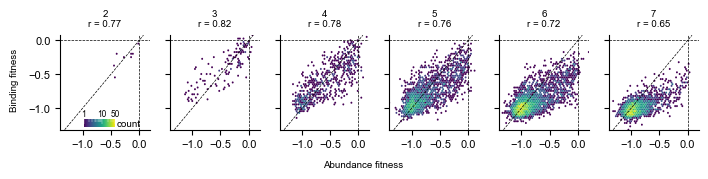

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.stats import pearsonr
import math

plt.rcParams['font.family'] = 'Arial'

xlim=(min(stability_vs_binding_scaled['stability_fitness']),max(stability_vs_binding_scaled['stability_fitness']))
ylim=(min(stability_vs_binding_scaled['binding_fitness']),max(stability_vs_binding_scaled['binding_fitness']))

fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(7,1.7))
coliterator=0
rowiterator=0
for hamm_dist in range(2,8,1):
    y = stability_vs_binding_scaled.loc[stability_vs_binding_scaled['Nham_aa_x']==hamm_dist][['binding_fitness']].to_numpy()
    x = stability_vs_binding_scaled.loc[stability_vs_binding_scaled['Nham_aa_x']==hamm_dist][['stability_fitness']].to_numpy()
    
    model = LinearRegression()
    model.fit(x,y)
    
    y_pred = model.predict(x)
    
    ax[coliterator].set(xlim=xlim,ylim=ylim)
    hbin=ax[coliterator].hexbin(x,y,gridsize=50,bins='log', vmax=50, rasterized=True,linewidths=0, extent=[min(stability_vs_binding_scaled['stability_fitness']),max(stability_vs_binding_scaled['stability_fitness']),min(stability_vs_binding_scaled['binding_fitness']),max(stability_vs_binding_scaled['binding_fitness'])])
    ax[coliterator].set_title(str(hamm_dist)+'\nr = '+str(round(pearsonr(x.ravel(),y.ravel())[0],2)), fontsize=7)
    ax[coliterator].axline((0, 0), slope=1,ls='dashed',color='k',lw=0.5)
    ax[coliterator].set_ylim(min(stability_vs_binding_scaled['binding_fitness']),max(stability_vs_binding_scaled['binding_fitness']))
    ax[coliterator].set_xlim(min(stability_vs_binding_scaled['stability_fitness']),max(stability_vs_binding_scaled['stability_fitness']))
    ax[coliterator].spines[['right','top']].set_visible(False)
    ax[coliterator].set_xticks([0,-0.5,-1])
    ax[coliterator].tick_params(axis='x', labelsize=8)
    ax[coliterator].tick_params(axis='y', labelsize=8)
    ax[coliterator].axhline(0, ls='--', color='k',lw=0.5)
    ax[coliterator].axvline(0, ls='--', color='k',lw=0.5)
    ax[coliterator].set_rasterization_zorder(0)
    if coliterator != 0:
        ax[coliterator].yaxis.set_ticklabels([])
    coliterator+=1
    

fmt = '%1.f'
cax=fig.add_axes([0.1,0.22,0.045,0.05])
cb=fig.colorbar(hbin, ax=ax, shrink=0.7,format=fmt,location='top',cax=cax)
cb.outline.set_visible(False)
cb.ax.tick_params(axis='both', which='both',direction='in', color='white',width=0.25)
cb.ax.xaxis.set_tick_params(pad=0)
cb.set_ticks([1,10,50])
cb.set_ticklabels([1,10,50], fontsize=6, rotation=0)
ax1 = cb.ax
ax1.text(60,0.1,'count',rotation=0, fontsize=7)

fig.text(0.5, -0.015, 'Abundance fitness', ha='center', fontsize=7)
fig.text(-0.005, 0.5, 'Binding fitness', va='center', rotation='vertical', fontsize=7)
fig.tight_layout()
plt.show()

## Panel I

Shift bindingPCA data sigma distribution for its mode to match the mode of abundancePCA data sigma distribution (required for folding coefficient stability, see methods)

0.13792021563046974

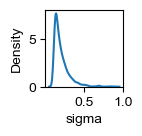

In [15]:
stabilityvars = stabilityvars.sort_values('fitness', ascending=False)

fig, ax = plt.subplots(figsize=(1,1))
my_kde = kdeplot(data=stabilityvars.loc[stabilityvars['WT']!=True], x='sigma', ax=ax)

lines = my_kde.get_lines()
#plt.close()
for line in lines:
    x, y = line.get_data()
    mode=(x[np.argmax(y)])

stability_mode = mode
mode

0.04536532735946337

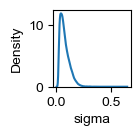

In [16]:
import pandas as pd
from seaborn import kdeplot
import numpy as np
import matplotlib.pyplot as plt

bindingvars = bindingvars.sort_values('fitness', ascending=False)

fig, ax = plt.subplots(figsize=(1,1))
my_kde = kdeplot(data=bindingvars.loc[bindingvars['WT']!=True], x='sigma', ax=ax)

lines = my_kde.get_lines()
#plt.close()
for line in lines:
    x, y = line.get_data()
    mode=(x[np.argmax(y)])

binding_mode = mode
mode

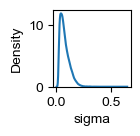

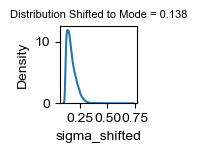

Original mode: 0.04536542199562474
Shift applied: 0.092554793634845


In [17]:
import pandas as pd
from seaborn import kdeplot
import numpy as np
import matplotlib.pyplot as plt

bindingvars = bindingvars.sort_values('fitness', ascending=False)

fig, ax = plt.subplots(figsize=(1,1))
my_kde = kdeplot(data=bindingvars, x='sigma', ax=ax)

lines = my_kde.get_lines()
for line in lines:
    x, y = line.get_data()
    current_mode = x[np.argmax(y)]

target_mode = stability_mode
shift = target_mode - current_mode 

bindingvars['sigma_shifted'] = bindingvars['sigma'] + shift

fig, ax = plt.subplots(figsize=(1,1))
kdeplot(data=bindingvars, x='sigma_shifted', ax=ax)
plt.title(f"Distribution Shifted to Mode = {round(target_mode,3)}", fontsize=8)
plt.show()

print(f"Original mode: {current_mode}")
print(f"Shift applied: {shift}")


In [18]:
fyn_wt = 'TLFVALYDYEARTEDDLSFHKGEKFQILNSSEGDWWEARSLTTGETGYIPSNYVAPV'
bindingvars.at[-1,'sigma']=1000
bindingvars.at[-1,'fitness']=0
bindingvars['WT']=np.nan
bindingvars.at[-1,'WT']=True
bindingvars.at[-1,'aa_seq']=fyn_wt

In [19]:
bindingvars.to_csv(path+'Fig7/FYN_bPCA_shifted_sigma_binding_fitness_replicates.txt',
                                           sep=',')

Model performance

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.stats import pearsonr
import math

quantile=1

full_models_terms_by_order = pd.DataFrame()
sprsreg_models_terms_by_order = pd.DataFrame()

overall_full_model_performance_stability = pd.DataFrame()
model_performance_by_nham_stability = pd.DataFrame()
sparse_model_performances_stability = pd.DataFrame()
sprsregmodel_performance_by_nham_stability = pd.DataFrame()

overall_full_model_performance = pd.DataFrame()
model_performance_by_nham = pd.DataFrame()
sparse_model_performances = pd.DataFrame()
sprsregmodel_performance_by_nham = pd.DataFrame()

model_names = {'1linear': '1', '1':'1', '2':'2', '2_sparseregularized':'2'}
tasks = {'1linear': '1', 'order1':'1', 'order2':'1', '2_sparse_regularized':'4'}

for model_name, task in zip(['1linear','1', '2', '2_sparseregularized'],['1','1','1','4']):
    for trait in ['Folding', 'Binding']:
        coefs = pd.read_csv(path+'Fig7/FYNbDTS_order'+model_name+'/task_'+task+'/weights/weights_'+trait+'.txt',
                                          sep='\t', low_memory=False)

        for index, row in coefs.iterrows():
            coefs.at[index,'order']=len(row.id.split('_'))
        for index, row in coefs['order'].value_counts().to_frame().iterrows():
            if model_name != '2_sparseregularized':
                full_models_terms_by_order.at[model_name,str(row.name)[:1]+'_'+trait]=row['count']
            else:
                sprsreg_models_terms_by_order.at[2,str(row.name)[:1]+'_'+trait]=row['count']
    
    predicted_phenotypes = pd.read_csv(path+'Fig7/FYNbDTS_order'+model_name+'/task_'+task+'/predictions/predicted_phenotypes_all.txt',
                                      sep='\t', lineterminator='\n', low_memory=False)

    predicted_phenotypes = predicted_phenotypes[predicted_phenotypes['sigma'] <= predicted_phenotypes['sigma'].quantile(quantile)].copy()
    
    for index, row in predicted_phenotypes.loc[predicted_phenotypes['WT']!=True].iterrows():
        predicted_phenotypes.at[index,'predicted_fitness']=row['fold_'+str(int(row['Fold']))]
    
    predicted_abundance = predicted_phenotypes.loc[predicted_phenotypes['Abundance']==1]
    predicted_binding = predicted_phenotypes.loc[predicted_phenotypes['Binding']==1]
    
    y = predicted_abundance.loc[predicted_abundance['WT']!=True][['fitness']].to_numpy()
    x = predicted_abundance.loc[predicted_abundance['WT']!=True][['predicted_fitness']].to_numpy()
    model = LinearRegression()
    model.fit(x,y)
    y_pred = model.predict(x)
    
    if model_name != '2_sparseregularized':
        overall_full_model_performance_stability.at[model_name,'All']=round(r2_score(y,y_pred),2)
    else:
        sparse_model_performances_stability.at['2','All']=round(r2_score(y,y_pred),2)

    y = predicted_binding.loc[predicted_binding['WT']!=True][['fitness']].to_numpy()
    x = predicted_binding.loc[predicted_binding['WT']!=True][['predicted_fitness']].to_numpy()

    model = LinearRegression()
    model.fit(x,y)
    y_pred = model.predict(x)
    
    if model_name != '2_sparseregularized':
        overall_full_model_performance.at[model_name,'All']=round(r2_score(y,y_pred),2)
    else:
        sparse_model_performances.at['2','All']=round(r2_score(y,y_pred),2)
    
    for hamm_dist in range(1,8,1):
        y = predicted_binding.loc[predicted_binding['WT']!=True].loc[predicted_binding['Nham_aa']==hamm_dist][['fitness']].to_numpy()
        x = predicted_binding.loc[predicted_binding['WT']!=True].loc[predicted_binding['Nham_aa']==hamm_dist][['predicted_fitness']].to_numpy()
        model = LinearRegression()
        model.fit(x,y)
        
        y_pred = model.predict(x)
        if model_name != '2_sparseregularized':
            model_performance_by_nham.at[model_name,hamm_dist]=round(r2_score(y,y_pred),2)
        else:
            sprsregmodel_performance_by_nham.at['2',hamm_dist]=round(r2_score(y,y_pred),2)       
        
        if hamm_dist > 1:
            y = predicted_abundance.loc[predicted_abundance['WT']!=True].loc[predicted_abundance['Nham_aa']==hamm_dist][['fitness']].to_numpy()
            x = predicted_abundance.loc[predicted_abundance['WT']!=True].loc[predicted_abundance['Nham_aa']==hamm_dist][['predicted_fitness']].to_numpy()
            
            model = LinearRegression()
            model.fit(x,y)
            
            y_pred = model.predict(x)
    
            if model_name != '2_sparseregularized':
                model_performance_by_nham_stability.at[model_name,hamm_dist]=round(r2_score(y,y_pred),2)
            else:
                sprsregmodel_performance_by_nham_stability.at['2',hamm_dist]=round(r2_score(y,y_pred),2)

sprsreg_models_terms_by_order=sprsreg_models_terms_by_order[full_models_terms_by_order.columns]

In [21]:
cummulative_sigma = 0
for index, row in bindingvars.loc[bindingvars['WT']!=True].iterrows():
    cummulative_sigma = cummulative_sigma + (row.sigma**2)

MEV = bindingvars.loc[bindingvars['WT']!=True].var(numeric_only=True)['fitness'] - (cummulative_sigma/len(bindingvars.index))
all_order_FEV = MEV/bindingvars.loc[bindingvars['WT']!=True].var(numeric_only=True)['fitness']

FEV_correction = pd.DataFrame()
for nham in range(1,8,1):
    nham_vars = bindingvars.loc[bindingvars['WT']!=True].loc[bindingvars['Nham_aa']==nham]
    
    cummulative_sigma = 0
    for index, row in nham_vars.iterrows():
        cummulative_sigma = cummulative_sigma + (row.sigma**2)
    
    MEV = nham_vars.var(numeric_only=True)['fitness'] - (cummulative_sigma/len(nham_vars.index))
    FEV = MEV/nham_vars.var(numeric_only=True)['fitness']
    FEV_correction.at[0,nham]=FEV

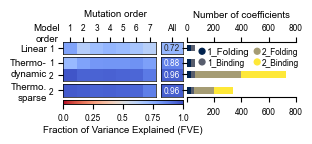

In [22]:
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch
import math

fig, ax = plt.subplot_mosaic([['top left', 'top centre', 'top right'],
                              ['biophys left', 'biophys centre', 'biophys right'],
                              ['middle left', 'middle centre', 'middle right'],
                              ['bottom left-centre', 'bottom left-centre', 'bottom right']],
                            width_ratios = [3, 0.7, 3.5],
                            height_ratios = [0.33, 0.67 ,0.37,0.1],
                            figsize=(3,0.8))

sns.heatmap(model_performance_by_nham.iloc[0:1].divide(FEV_correction.loc[0],axis=1).clip(upper=1), annot=False, fmt=".2f", cmap='coolwarm_r', vmin=0, vmax=1,ax=ax['top left'], linewidths=0, linecolor='black', annot_kws={'color':'black', 'font':'Arial', 'size':6}, center=0.5, cbar=False)
sns.heatmap(model_performance_by_nham.iloc[1:].divide(FEV_correction.loc[0],axis=1).clip(upper=1), annot=False, fmt=".2f", cmap='coolwarm_r', vmin=0, vmax=1,ax=ax['biophys left'], linewidths=0, linecolor='black', annot_kws={'color':'black', 'font':'Arial', 'size':6}, center=0.5, cbar=False)
sns.heatmap(sprsregmodel_performance_by_nham.divide(FEV_correction.loc[0],axis=1).apply(pd.to_numeric).clip(upper=1), annot=False, fmt=".2f", cmap='coolwarm_r', vmin=0, vmax=1,ax=ax['middle left'], linewidths=0, linecolor='black', annot_kws={'color':'black', 'font':'Arial', 'size':6}, center=0.5,cbar_ax=ax['bottom left-centre'],cbar_kws={"orientation": "horizontal", 'location':'bottom'})

ax['top left'].set_xticks([i+0.5 for i in range(model_performance_by_nham.shape[1])])
ax['top left'].set_xticklabels(model_performance_by_nham.columns, fontsize=6, rotation=0)
ax['top left'].set_yticks([0.5])
ax['top left'].set_yticklabels(['1'], fontsize=6, rotation=0)
ax['top left'].xaxis.set_label_position('top')
ax['top left'].xaxis.set_ticks_position('top')
ax['top left'].tick_params(axis='both',labelsize=6, labelrotation=0)
ax['middle left'].set_yticks([i+0.5 for i in range(sprsregmodel_performance_by_nham.shape[0])])
ax['middle left'].set_yticklabels([str(i+2) for i in range(sprsregmodel_performance_by_nham.shape[0])], fontsize=6, rotation=0)
ax['middle left'].tick_params(axis='both',labelsize=6, labelrotation=0)
ax['middle left'].set_xticks(ticks=[])
ax['biophys left'].set_yticks([i+0.5 for i in range(model_performance_by_nham.shape[0]-1)])
ax['biophys left'].set_yticklabels([str(i+1) for i in range(model_performance_by_nham.shape[0]-1)], fontsize=6, rotation=0)
ax['biophys left'].tick_params(axis='both',labelsize=6, labelrotation=0)
ax['biophys left'].set_xticks(ticks=[])
ax['bottom left-centre'].set_xticks(ticks=np.arange(0,1.25,.25),labels=np.arange(0,1.25,.25), fontsize=6)
ax['bottom left-centre'].set_xlabel('Fraction of Variance Explained (FVE)', rotation=0, labelpad=2, fontsize=7)

sns.heatmap((overall_full_model_performance.iloc[0:1]/all_order_FEV).clip(upper=1), annot=True, fmt=".2f", cmap='coolwarm_r', vmin=0, vmax=1,ax=ax['top centre'], linewidths=0, linecolor='black', annot_kws={'ha': 'center', 'va': 'center','font':'Arial', 'size':6}, center=0.5, cbar=False)
ax['top centre'].set_yticks(ticks=[])
ax['top centre'].set_xticks([i+0.5 for i in range(overall_full_model_performance.shape[1])])
ax['top centre'].set_xticklabels(overall_full_model_performance.columns, fontsize=6, rotation=0)
ax['top centre'].xaxis.set_label_position('top')
ax['top centre'].xaxis.set_ticks_position('top')
ax['top centre'].tick_params(axis='both',labelsize=6, labelrotation=0)

sns.heatmap((overall_full_model_performance.iloc[1:]/all_order_FEV).clip(upper=1), annot=True, fmt=".2f", cmap='coolwarm_r', vmin=0, vmax=1,ax=ax['biophys centre'], linewidths=0, linecolor='black', annot_kws={'ha': 'center', 'va': 'center','font':'Arial', 'size':6}, center=0.5, cbar=False)
ax['biophys centre'].set_yticks(ticks=[])
ax['biophys centre'].set_xticks(ticks=[])

sns.heatmap((sparse_model_performances/all_order_FEV).clip(upper=1), annot=True, fmt=".2f", cmap='coolwarm_r', vmin=0, vmax=1,ax=ax['middle centre'], linewidths=0, linecolor='black', annot_kws={'ha': 'center', 'va': 'center','font':'Arial', 'size':6}, center=0.5, cbar=False)
ax['middle centre'].set_yticks(ticks=[])
ax['middle centre'].set_xticks(ticks=[])

full_models_terms_by_order.iloc[0:1].plot(kind='barh', stacked=True, cmap='cividis', ax=ax['top right'], legend=False, width=0.65)
ax['top right'].invert_yaxis()
ax['top right'].spines[['right','bottom','left']].set_visible(False)
ax['top right'].xaxis.set_label_position('top')
ax['top right'].xaxis.set_ticks_position('top')
ax['top right'].set_xlabel('Number of coefficients', fontsize=7)
ax['top right'].set_yticks(ticks=np.arange(0,1,1), labels=[])
ax['top right'].set_xticks(ticks=np.arange(0,math.ceil(max(full_models_terms_by_order.sum(axis=1)) / 200) *200 +200,200),labels=np.arange(0,math.ceil(max(full_models_terms_by_order.sum(axis=1)) / 200) *200+200,200), fontsize=6)
ax['top right'].set_xlim(0,math.ceil(max(full_models_terms_by_order.sum(axis=1)) / 200) *200)
ax['top right'].tick_params(axis='both',labelsize=6, labelrotation=0)

full_models_terms_by_order.iloc[1:].plot(kind='barh', stacked=True, cmap='cividis', ax=ax['biophys right'], legend=False, width=0.65)
ax['biophys right'].invert_yaxis()
ax['biophys right'].spines[['right','bottom','left','top']].set_visible(False)
ax['biophys right'].set_yticks(ticks=np.arange(0,2,1), labels=[])
ax['biophys right'].set_xticks(ticks=[],labels=[])
ax['biophys right'].set_xlim(0,math.ceil(max(full_models_terms_by_order.sum(axis=1)) / 200) *200)
ax['biophys right'].tick_params(axis='both',labelsize=6, labelrotation=0)

sprsreg_models_terms_by_order.plot(kind='barh', stacked=True, cmap='cividis', ax=ax['middle right'], legend=False, width=0.6)
ax['middle right'].invert_yaxis()
handles, labels = ax['middle right'].get_legend_handles_labels()
ax['middle right'].spines[['right','top','left']].set_visible(False)
ax['middle right'].set_yticks(ticks=np.arange(0,1,1),labels=[])
ax['middle right'].set_xticks(ticks=np.arange(0,math.ceil(max(full_models_terms_by_order.sum(axis=1)) / 200) *200 +200,200),labels=['']+[str(i) for i in np.arange(200,math.ceil(max(full_models_terms_by_order.sum(axis=1)) / 200) *200+200,200)], fontsize=6)
ax['middle right'].set_xlim(0,math.ceil(max(full_models_terms_by_order.sum(axis=1)) / 200) *200)
ax['middle right'].xaxis.set_ticks_position('bottom')

for axis in ['top left', 'biophys left', 'middle left', 'bottom left-centre', 'top centre', 'biophys centre', 'middle centre']:
    for spine in ax[axis].spines.values():
        spine.set(visible=True,lw=0.5,edgecolor='black')

ax['bottom right'].axis('off')

class HandlerCircle(HandlerPatch):
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        center = (width / 2, height / 2)
        p = mpatches.Circle(center, radius=min(width, height) / 2, color=orig_handle.get_facecolor())
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

circle_handles = [mpatches.Circle((0, 0), radius=3, color=h.patches[0].get_facecolor()) for h in handles]

legend_labels = labels

circle_handles = circle_handles

legend = ax['bottom right'].legend(circle_handles, legend_labels,
                                   handler_map={mpatches.Circle: HandlerCircle()},
                                   ncol=2,
                                   frameon=False, fontsize=6,
                                   loc='lower center',
                                   bbox_to_anchor=(0.57, 8),
                                   handletextpad=0.2,
                                   labelspacing=0.2,
                                   handlelength=0.8,
                                   columnspacing=0.5)

legend.get_texts()[0].set_fontsize(7)


for plot_name, df in zip(['top right', 'biophys right', 'middle right'],
                         [full_models_terms_by_order.T.iloc[0:1],
                          full_models_terms_by_order.T.iloc[1:],
                          sprsreg_models_terms_by_order.T]):
    totals = df.iloc[-1]
    
    for i, total in enumerate(totals):
        if not (plot_name == 'middle right' and i == len(totals) - 1):
            try:
                continue
            except ValueError:
                continue

    if plot_name == 'middle right':
        last_total = totals.iloc[-1]
        penultimate_total = full_models_terms_by_order.T.iloc[1:].sum(axis=1).iloc[-1]
        percentage = (last_total / penultimate_total) * 100 if penultimate_total != 0 else 0
        
fig.text(0.3, 1.2, 'Mutation order', ha='center', fontsize=7)
fig.text(0.07, 0.89, 'Model\norder', ha='center', fontsize=7)
fig.text(0.07, 0.8, 'Linear', va='center', ha='right', rotation='horizontal', fontsize=7)
fig.text(0.07, 0.55, 'Thermo-\ndynamic', va='center', ha='right', rotation='horizontal', fontsize=7)
fig.text(0.07, 0.25, 'Thermo.\nsparse', va='center', ha='right', rotation='horizontal', fontsize=7)

plt.subplots_adjust(hspace=0.2, wspace= 0.06)

plt.show()

In [23]:
cummulative_sigma = 0
for index, row in stabilityvars.loc[stabilityvars['WT']!=True].iterrows():
    cummulative_sigma = cummulative_sigma + (row.sigma**2)

MEV = stabilityvars.loc[stabilityvars['WT']!=True].var(numeric_only=True)['fitness'] - (cummulative_sigma/len(stabilityvars.iloc[:-1].index))
all_order_FEV_stability = MEV/stabilityvars.loc[stabilityvars['WT']!=True].var(numeric_only=True)['fitness']

FEV_correction_stability = pd.DataFrame()
for nham in range(2,8,1):
    nham_vars = stabilityvars.loc[stabilityvars['WT']!=True].loc[stabilityvars.loc[stabilityvars['WT']!=True]['Nham_aa']==nham]
    
    cummulative_sigma = 0
    for index, row in nham_vars.iterrows():
        cummulative_sigma = cummulative_sigma + (row.sigma**2)
    
    MEV = nham_vars.var(numeric_only=True)['fitness'] - (cummulative_sigma/len(nham_vars.index))
    FEV = MEV/nham_vars.var(numeric_only=True)['fitness']
    FEV_correction_stability.at[0,nham]=FEV


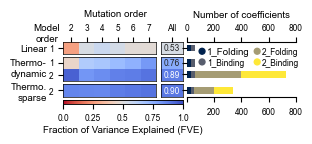

In [24]:
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch
import math

fig, ax = plt.subplot_mosaic([['top left', 'top centre', 'top right'],
                              ['biophys left', 'biophys centre', 'biophys right'],
                              ['middle left', 'middle centre', 'middle right'],
                              ['bottom left-centre', 'bottom left-centre', 'bottom right']],
                            width_ratios = [3, 0.7, 3.5],
                            height_ratios = [0.33, 0.67 ,0.37,0.1],
                            figsize=(3,0.8))

sns.heatmap(model_performance_by_nham_stability.iloc[0:1].divide(FEV_correction_stability.loc[0],axis=1).clip(upper=1), annot=False, fmt=".2f", cmap='coolwarm_r', vmin=0, vmax=1,ax=ax['top left'], linewidths=0, linecolor='black', annot_kws={'color':'black', 'font':'Arial', 'size':6}, center=0.5, cbar=False)
sns.heatmap(model_performance_by_nham_stability.iloc[1:].divide(FEV_correction_stability.loc[0],axis=1).clip(upper=1), annot=False, fmt=".2f", cmap='coolwarm_r', vmin=0, vmax=1,ax=ax['biophys left'], linewidths=0, linecolor='black', annot_kws={'color':'black', 'font':'Arial', 'size':6}, center=0.5, cbar=False)
sns.heatmap(sprsregmodel_performance_by_nham_stability.divide(FEV_correction_stability.loc[0],axis=1).apply(pd.to_numeric).clip(upper=1), annot=False, fmt=".2f", cmap='coolwarm_r', vmin=0, vmax=1,ax=ax['middle left'], linewidths=0, linecolor='black', annot_kws={'color':'black', 'font':'Arial', 'size':6}, center=0.5,cbar_ax=ax['bottom left-centre'],cbar_kws={"orientation": "horizontal", 'location':'bottom'})

#ax['top left'].set_xlabel('Mutation order', fontsize=7)
# Setting y-tick labels explicitly to ensure visibility
ax['top left'].set_xticks([i+0.5 for i in range(model_performance_by_nham_stability.shape[1])])
ax['top left'].set_xticklabels(model_performance_by_nham_stability.columns, fontsize=6, rotation=0)
ax['top left'].set_yticks([0.5])
ax['top left'].set_yticklabels(['1'], fontsize=6, rotation=0)
ax['top left'].xaxis.set_label_position('top')
ax['top left'].xaxis.set_ticks_position('top')
ax['top left'].tick_params(axis='both',labelsize=6, labelrotation=0)
ax['middle left'].set_yticks([i+0.5 for i in range(sprsregmodel_performance_by_nham_stability.shape[0])])
ax['middle left'].set_yticklabels([str(i+2) for i in range(sprsregmodel_performance_by_nham_stability.shape[0])], fontsize=6, rotation=0)
ax['middle left'].tick_params(axis='both',labelsize=6, labelrotation=0)
ax['middle left'].set_xticks(ticks=[])
ax['biophys left'].set_yticks([i+0.5 for i in range(model_performance_by_nham_stability.shape[0]-1)])
ax['biophys left'].set_yticklabels([str(i+1) for i in range(model_performance_by_nham_stability.shape[0]-1)], fontsize=6, rotation=0)
ax['biophys left'].tick_params(axis='both',labelsize=6, labelrotation=0)
ax['biophys left'].set_xticks(ticks=[])
ax['bottom left-centre'].set_xticks(ticks=np.arange(0,1.25,.25),labels=np.arange(0,1.25,.25), fontsize=6)
ax['bottom left-centre'].set_xlabel('Fraction of Variance Explained (FVE)', rotation=0, labelpad=2, fontsize=7)

sns.heatmap((overall_full_model_performance_stability.iloc[0:1]/all_order_FEV_stability).clip(upper=1), annot=True, fmt=".2f", cmap='coolwarm_r', vmin=0, vmax=1,ax=ax['top centre'], linewidths=0, linecolor='black', annot_kws={'ha': 'center', 'va': 'center','font':'Arial', 'size':6}, center=0.5, cbar=False)
ax['top centre'].set_yticks(ticks=[])
ax['top centre'].set_xticks([i+0.5 for i in range(overall_full_model_performance_stability.shape[1])])
ax['top centre'].set_xticklabels(overall_full_model_performance_stability.columns, fontsize=6, rotation=0)
ax['top centre'].xaxis.set_label_position('top')
ax['top centre'].xaxis.set_ticks_position('top')
ax['top centre'].tick_params(axis='both',labelsize=6, labelrotation=0)

sns.heatmap((overall_full_model_performance_stability.iloc[1:]/all_order_FEV_stability).clip(upper=1), annot=True, fmt=".2f", cmap='coolwarm_r', vmin=0, vmax=1,ax=ax['biophys centre'], linewidths=0, linecolor='black', annot_kws={'ha': 'center', 'va': 'center','font':'Arial', 'size':6}, center=0.5, cbar=False)
ax['biophys centre'].set_yticks(ticks=[])
ax['biophys centre'].set_xticks(ticks=[])

sns.heatmap((sparse_model_performances_stability/all_order_FEV_stability).clip(upper=1), annot=True, fmt=".2f", cmap='coolwarm_r', vmin=0, vmax=1,ax=ax['middle centre'], linewidths=0, linecolor='black', annot_kws={'ha': 'center', 'va': 'center','font':'Arial', 'size':6}, center=0.5, cbar=False)
ax['middle centre'].set_yticks(ticks=[])
ax['middle centre'].set_xticks(ticks=[])

full_models_terms_by_order.iloc[0:1].plot(kind='barh', stacked=True, cmap='cividis', ax=ax['top right'], legend=False, width=0.65)
ax['top right'].invert_yaxis()
ax['top right'].spines[['right','bottom','left']].set_visible(False)
ax['top right'].xaxis.set_label_position('top')
ax['top right'].xaxis.set_ticks_position('top')
ax['top right'].set_xlabel('Number of coefficients', fontsize=7)
ax['top right'].set_yticks(ticks=np.arange(0,1,1), labels=[])
ax['top right'].set_xticks(ticks=np.arange(0,math.ceil(max(full_models_terms_by_order.sum(axis=1)) / 200) *200 +200,200),labels=np.arange(0,math.ceil(max(full_models_terms_by_order.sum(axis=1)) / 200) *200+200,200), fontsize=6)
ax['top right'].set_xlim(0,math.ceil(max(full_models_terms_by_order.sum(axis=1)) / 200) *200)
ax['top right'].tick_params(axis='both',labelsize=6, labelrotation=0)

full_models_terms_by_order.iloc[1:].plot(kind='barh', stacked=True, cmap='cividis', ax=ax['biophys right'], legend=False, width=0.65)
ax['biophys right'].invert_yaxis()
ax['biophys right'].spines[['right','bottom','left','top']].set_visible(False)
ax['biophys right'].set_yticks(ticks=np.arange(0,2,1), labels=[])
ax['biophys right'].set_xticks(ticks=[],labels=[])
ax['biophys right'].set_xlim(0,math.ceil(max(full_models_terms_by_order.sum(axis=1)) / 200) *200)
ax['biophys right'].tick_params(axis='both',labelsize=6, labelrotation=0)

sprsreg_models_terms_by_order.plot(kind='barh', stacked=True, cmap='cividis', ax=ax['middle right'], legend=False, width=0.6)
ax['middle right'].invert_yaxis()
handles, labels = ax['middle right'].get_legend_handles_labels()
ax['middle right'].spines[['right','top','left']].set_visible(False)
ax['middle right'].set_yticks(ticks=np.arange(0,1,1),labels=[])
ax['middle right'].set_xticks(ticks=np.arange(0,math.ceil(max(full_models_terms_by_order.sum(axis=1)) / 200) *200 +200,200),labels=['']+[str(i) for i in np.arange(200,math.ceil(max(full_models_terms_by_order.sum(axis=1)) / 200) *200+200,200)], fontsize=6)
ax['middle right'].set_xlim(0,math.ceil(max(full_models_terms_by_order.sum(axis=1)) / 200) *200)
ax['middle right'].xaxis.set_ticks_position('bottom')

for axis in ['top left', 'biophys left', 'middle left', 'bottom left-centre', 'top centre', 'biophys centre', 'middle centre']:
    for spine in ax[axis].spines.values():
        spine.set(visible=True,lw=0.5,edgecolor='black')

ax['bottom right'].axis('off')

class HandlerCircle(HandlerPatch):
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        # Create a circle artist
        center = (width / 2, height / 2)
        p = mpatches.Circle(center, radius=min(width, height) / 2, color=orig_handle.get_facecolor())
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

circle_handles = [mpatches.Circle((0, 0), radius=3, color=h.patches[0].get_facecolor()) for h in handles]

legend_labels = labels
circle_handles = circle_handles

legend = ax['bottom right'].legend(circle_handles, legend_labels,
                                   handler_map={mpatches.Circle: HandlerCircle()},
                                   ncol=2,
                                   frameon=False, fontsize=6,
                                   loc='lower center',
                                   bbox_to_anchor=(0.57, 8),
                                   handletextpad=0.2,
                                   labelspacing=0.2,
                                   handlelength=0.8,
                                   columnspacing=0.5)

legend.get_texts()[0].set_fontsize(7)


for plot_name, df in zip(['top right', 'biophys right', 'middle right'],
                         [full_models_terms_by_order.T.iloc[0:1],
                          full_models_terms_by_order.T.iloc[1:],
                          sprsreg_models_terms_by_order.T]):
    totals = df.iloc[-1]
    
    for i, total in enumerate(totals):
        if not (plot_name == 'middle right' and i == len(totals) - 1):
            try:
                continue
            except ValueError:
                continue

    if plot_name == 'middle right':
        last_total = totals.iloc[-1]
        penultimate_total = full_models_terms_by_order.T.iloc[1:].sum(axis=1).iloc[-1]
        percentage = (last_total / penultimate_total) * 100 if penultimate_total != 0 else 0

fig.text(0.3, 1.2, 'Mutation order', ha='center', fontsize=7)
fig.text(0.07, 0.89, 'Model\norder', ha='center', fontsize=7)
fig.text(0.07, 0.8, 'Linear', va='center', ha='right', rotation='horizontal', fontsize=7)
fig.text(0.07, 0.55, 'Thermo-\ndynamic', va='center', ha='right', rotation='horizontal', fontsize=7)
fig.text(0.07, 0.25, 'Thermo.\nsparse', va='center', ha='right', rotation='horizontal', fontsize=7)

plt.subplots_adjust(hspace=0.2, wspace= 0.06)

plt.show()

## Panel J

In [25]:
import pandas as pd

predicted_phenotypes = pd.read_csv(path+'Fig7/FYNbDTS_order2/task_1/predictions/predicted_phenotypes_all.txt',
                                           sep='\t')

predicted_abundance = predicted_phenotypes.loc[predicted_phenotypes['Abundance']==1]
predicted_binding = predicted_phenotypes.loc[predicted_phenotypes['Binding']==1]

In [26]:
# Normalize data

from seaborn import kdeplot
import numpy as np
import matplotlib.pyplot as plt

RT=303*0.001987

predicted_abundance_scaled = predicted_abundance.copy()
predicted_binding_scaled = predicted_binding.copy()

def normalize(values, bounds):
    return [bounds['desired']['lower'] + (x - bounds['actual']['lower']) * (bounds['desired']['upper'] - bounds['desired']['lower']) / (bounds['actual']['upper'] - bounds['actual']['lower']) for x in values]

# Normalize abundance fitness measurements

fig, ax = plt.subplots()

my_kde = kdeplot(data=predicted_abundance, x='fitness', ax=ax)

lines = my_kde.get_lines()
plt.close()
for line in lines:
    x, y = line.get_data()
    mode=(x[np.argmax(y)])


predicted_abundance_scaled['fitness']=        normalize(list(predicted_abundance_scaled['fitness']),{'actual': {'lower': mode, 'upper':         0}, 'desired': {'lower': -1, 'upper': 0}})
predicted_abundance_scaled['fitness1_uncorr']=normalize(list(predicted_abundance_scaled['fitness1_uncorr']),{'actual': {'lower': mode, 'upper': 0}, 'desired': {'lower': -1, 'upper': 0}})
predicted_abundance_scaled['fitness2_uncorr']=normalize(list(predicted_abundance_scaled['fitness2_uncorr']),{'actual': {'lower': mode, 'upper': 0}, 'desired': {'lower': -1, 'upper': 0}})

# Normalize abundance fitness predictions

for index, row in predicted_abundance_scaled.loc[predicted_abundance_scaled['WT']!=True].iterrows():
    predicted_abundance_scaled.at[index,'predicted_fitness']=row['fold_'+str(int(row['Fold']))]
    predicted_abundance_scaled.at[index,'predicted_dG']=row['fold_'+str(int(row['Fold']))+'_additive_trait0']*RT

fig, ax = plt.subplots()

my_kde = kdeplot(data=predicted_abundance_scaled, x='predicted_fitness', ax=ax)

lines = my_kde.get_lines()
plt.close()
for line in lines:
    x, y = line.get_data()
    mode=(x[np.argmax(y)])

predicted_abundance_scaled['predicted_fitness']=           normalize(list(predicted_abundance_scaled['predicted_fitness']),{'actual': {'lower': mode, 'upper': 0}, 'desired': {'lower': -1, 'upper': 0}})

# Obtain mean inferred folding dGs

predicted_abundance_scaled['mean_additive_trait']=predicted_abundance_scaled[['fold_'+str(i)+'_additive_trait0' for i in range(1,11,1)]].mean(axis=1)
predicted_abundance_scaled['std_additive_trait']=predicted_abundance_scaled[['fold_'+str(i)+'_additive_trait0' for i in range(1,11,1)]].std(axis=1)

predicted_abundance_scaled['mean_dG']= predicted_abundance_scaled['mean_additive_trait']*RT
predicted_abundance_scaled['std_dG']=  predicted_abundance_scaled['std_additive_trait']*RT

# Normalize binding fitness measurements

fig, ax = plt.subplots()

my_kde = kdeplot(data=predicted_binding, x='fitness', ax=ax)

lines = my_kde.get_lines()
plt.close()
for line in lines:
    x, y = line.get_data()
    mode=(x[np.argmax(y)])


predicted_binding_scaled['fitness']=        normalize(list(predicted_binding_scaled['fitness']),{'actual': {'lower': mode, 'upper':         0}, 'desired': {'lower': -1, 'upper': 0}})
predicted_binding_scaled['fitness1_uncorr']=normalize(list(predicted_binding_scaled['fitness1_uncorr']),{'actual': {'lower': mode, 'upper': 0}, 'desired': {'lower': -1, 'upper': 0}})
predicted_binding_scaled['fitness2_uncorr']=normalize(list(predicted_binding_scaled['fitness2_uncorr']),{'actual': {'lower': mode, 'upper': 0}, 'desired': {'lower': -1, 'upper': 0}})
predicted_binding_scaled['fitness3_uncorr']=normalize(list(predicted_binding_scaled['fitness3_uncorr']),{'actual': {'lower': mode, 'upper': 0}, 'desired': {'lower': -1, 'upper': 0}})

# Normalize binding fitness predictions

for index, row in predicted_binding_scaled.loc[predicted_binding_scaled['WT']!=True].iterrows():
    predicted_binding_scaled.at[index,'predicted_fitness']=row['fold_'+str(int(row['Fold']))]
    predicted_binding_scaled.at[index,'predicted_dG']=row['fold_'+str(int(row['Fold']))+'_additive_trait0']*RT

fig, ax = plt.subplots()

my_kde = kdeplot(data=predicted_binding_scaled, x='predicted_fitness', ax=ax)

lines = my_kde.get_lines()
plt.close()
for line in lines:
    x, y = line.get_data()
    mode=(x[np.argmax(y)])

predicted_binding_scaled['predicted_fitness']=           normalize(list(predicted_binding_scaled['predicted_fitness']),{'actual': {'lower': mode, 'upper': 0}, 'desired': {'lower': -1, 'upper': 0}})

# Obtain mean inferred binding dGs

predicted_binding_scaled['mean_additive_trait']=predicted_binding_scaled[['fold_'+str(i)+'_additive_trait1' for i in range(1,11,1)]].mean(axis=1)
predicted_binding_scaled['std_additive_trait']=predicted_binding_scaled[['fold_'+str(i)+'_additive_trait1' for i in range(1,11,1)]].std(axis=1)

predicted_binding_scaled['mean_dG']= predicted_binding_scaled['mean_additive_trait']*RT
predicted_binding_scaled['std_dG']=  predicted_binding_scaled['std_additive_trait']*RT

In [27]:
predicted_abundance_scaled = predicted_abundance_scaled.rename(columns={'predicted_fitness': 'predicted_stability_fitness'})
predicted_binding_scaled = predicted_binding_scaled.rename(columns={'predicted_fitness': 'predicted_binding_fitness'})
predicted_abundance_scaled = predicted_abundance_scaled.rename(columns={'fitness': 'stability_fitness'})
predicted_binding_scaled = predicted_binding_scaled.rename(columns={'fitness': 'binding_fitness'})
predicted_abundance_scaled = predicted_abundance_scaled.rename(columns={'mean_dG': 'folding_dG'})
predicted_binding_scaled = predicted_binding_scaled.rename(columns={'mean_dG': 'binding_dG'})
predicted_stability_vs_binding = predicted_binding_scaled.merge(predicted_abundance_scaled, left_on='aa_seq', right_on='aa_seq')

In [28]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class MyAxes3D(Axes3D):

    def __init__(self, baseObject, sides_to_draw):
        self.__class__ = type(baseObject.__class__.__name__,
                              (self.__class__, baseObject.__class__),
                              {})
        self.__dict__ = baseObject.__dict__
        self.sides_to_draw = list(sides_to_draw)
        self.mouse_init()

    def set_some_features_visibility(self, visible):
        for t in self.zaxis.get_ticklines() + self.zaxis.get_ticklabels():
            t.set_visible(visible)
        self.zaxis.line.set_visible(visible)
        self.zaxis.pane.set_visible(visible)
        self.zaxis.label.set_visible(visible)
        

    def draw(self, renderer):

        self.set_some_features_visibility(True)

        super(MyAxes3D, self).draw(renderer)

        self.set_some_features_visibility(True)

        zaxis = self.zaxis
        draw_grid_old = zaxis.axes._draw_grid

        tmp_planes = zaxis._PLANES

        if 'l' in self.sides_to_draw :
            # draw zaxis on the left side
            zaxis._PLANES = (tmp_planes[2], tmp_planes[3],
                             tmp_planes[0], tmp_planes[1],
                             tmp_planes[4], tmp_planes[5])
            zaxis.draw(renderer)
        if 'r' in self.sides_to_draw :
            # draw zaxis on the right side
            zaxis._PLANES = (tmp_planes[3], tmp_planes[2], 
                             tmp_planes[1], tmp_planes[0], 
                             tmp_planes[4], tmp_planes[5])
            zaxis.draw(renderer)

        zaxis._PLANES = tmp_planes


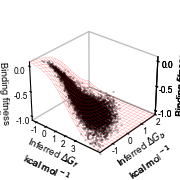

In [29]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the modified sigmoid function in 3D with upper and lower plateaus
def sigmoid_3d(xy, a, b, c, lower_plateau, upper_plateau):
    x, y = xy
    return lower_plateau + (upper_plateau - lower_plateau) / (1 + np.exp(-(a*x + b*y + c)))

# Define data
x_data = predicted_stability_vs_binding['folding_dG'].to_numpy()
y_data = predicted_stability_vs_binding['binding_dG'].to_numpy()
z_data = predicted_stability_vs_binding['binding_fitness'].to_numpy()

# Initial guess for parameters
lower_plateau=min(z_data)
upper_plateau=max(z_data)
initial_guess = (1, 1, 1, lower_plateau, upper_plateau)

# Fit the modified 3D sigmoid surface to the data
params, covariance = curve_fit(sigmoid_3d, (x_data, y_data), z_data, p0=initial_guess)

# Extract the fitted parameters
a, b, c, lower_plateau_fit, upper_plateau_fit = params

# Create a meshgrid within the range [-2, 2] for plotting the surface
x_mesh, y_mesh = np.meshgrid(np.linspace(min(x_data), max(x_data), 100), np.linspace(min(y_data), max(y_data), 100))
z_fit = sigmoid_3d((x_mesh, y_mesh), a, b, c, lower_plateau_fit, upper_plateau_fit)

# Calculate the minimum and maximum values of the fitted surface
z_min, z_max = np.min(z_fit), np.max(z_fit)
x_min, x_max = np.min(x_mesh), np.max(x_mesh)
y_min, y_max = np.min(y_mesh), np.max(y_mesh)

# Plot the original data points and the fitted wireframe surface
fig = plt.figure(figsize=(1.8,1.8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_data, y_data, z_data, color='black', label='Original Data', alpha=0.5, s=0.1, rasterized=True)
surf = ax.plot_wireframe(x_mesh, y_mesh, z_fit, color='red', label='Fitted Surface', rstride=5, cstride=5, linewidth=0.1)

# Set xlim, ylim, and zlim to touch the axes
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_zlim(z_min, z_max)

ax.set_xlabel(r'Inferred ${ΔG_{f}}$'+ '\n'+ r'kcal mol$^-$$^1$', fontsize=7, labelpad=-8)
ax.set_ylabel(r'Inferred ${ΔG_{b}}$'+ '\n'+ r'kcal mol$^-$$^1$', fontsize=7, labelpad=-8)
ax.set_zlabel('Binding fitness\n(observed)', fontsize=7, labelpad=-8)
ax.tick_params(axis="y", pad=-6)
ax.tick_params(axis="z", pad=-4)
ax.tick_params(axis="x", pad=-6)
ax.set_xticks(np.arange(-1,4,1),labels=np.arange(-1,4,1),fontsize=6)
ax.set_yticks(np.arange(-1,3,1),labels=np.arange(-1,3,1),fontsize=6)
ax.set_zticks(np.arange(-1,0.5,0.5),labels=np.arange(-1,0.5,0.5),fontsize=6)

ax.set_rasterization_zorder(0)

ax.grid(False)
ax.xaxis.pane.set_edgecolor('gray')
ax.yaxis.pane.set_edgecolor('gray')
ax.zaxis.pane.set_edgecolor('gray')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax = fig.add_axes(MyAxes3D(ax, 'lr'))
ax.view_init(elev=30, azim=310)

plt.show()

## Panel K

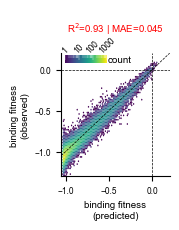

In [30]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':'tight'}

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

overall_full_model_performance = pd.DataFrame()

y = predicted_binding_scaled.loc[predicted_binding_scaled['WT']!=True].loc[predicted_binding_scaled['predicted_binding_fitness'].notnull()][['binding_fitness']].to_numpy()
x = predicted_binding_scaled.loc[predicted_binding_scaled['WT']!=True].loc[predicted_binding_scaled['predicted_binding_fitness'].notnull()][['predicted_binding_fitness']].to_numpy()
model = LinearRegression()
model.fit(x,y)
y_pred = model.predict(x)

fig, ax = plt.subplots(figsize=(1.4,1.6))
hbin=ax.hexbin(x=predicted_binding_scaled['predicted_binding_fitness'].loc[predicted_binding_scaled['WT']!=True],y=predicted_binding_scaled['binding_fitness'].loc[predicted_binding_scaled['WT']!=True],bins='log',gridsize=75,rasterized=True,linewidths=0,vmax=1000)
ax.axline((0.1, 0.1), slope=1, linestyle = "dashed", color = 'black',lw=0.5)


plt.axvline(0, ls='--', color='black', lw=0.5)
plt.axhline(0, ls='--', color='black', lw=0.5)
plt.title('\nR$^2$='+str(round(r2_score(y,y_pred),2))+' | MAE='+str(round(mean_absolute_error(y,y_pred),3)),fontsize=7, color='r', loc='center',pad=15)
overall_full_model_performance.at['1','All']=round(r2_score(y,y_pred),2)
plt.xlabel('binding fitness\n(predicted)', fontsize=7)
plt.xticks(fontsize=6)
plt.ylabel('binding fitness\n(observed)', fontsize=7)
plt.yticks(fontsize=6)
ax.set_xticks(np.arange(-1.5,0.5,0.5))
ax.set_yticks(np.arange(-1.5,0.5,0.5))
ax.set_ylim(-1.3,0.2)
ax.set_xlim(-1.05,0.2)
ax.spines[['top','right']].set_visible(False)
ax.set_rasterization_zorder(0)
fmt = '%1.f'
cax=fig.add_axes([0.15,0.82,0.3,0.05])
cb=fig.colorbar(hbin, ax=ax, shrink=0.7,format=fmt,location='top',cax=cax)
cb.outline.set_visible(False)
cb.ax.tick_params(axis='both', which='both',direction='in', color='white',width=0.25)
cb.ax.xaxis.set_tick_params(pad=0)
cb.set_ticks([1,10,100,1000])
cb.set_ticklabels([1,10,100,1000], fontsize=6, rotation=45)
ax1 = cb.ax
ax1.text(1200,0.1,'count',rotation=0, fontsize=7)
plt.show()

## Panel L

In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from matplotlib.lines import Line2D  # For adding custom legend markers

nardo_etal_table2 = pd.read_csv(path+'Fig7/nardo_etal_table2_fyn_bindingddGs_invitro.txt',sep='\t',index_col=0)

model_names = {'order2': '2'}
tasks = {'order2': '1'}

for mochi_model in model_names.keys():

    coefs = pd.read_csv(path + 'Fig7/FYNbDTS_order2/task_1/weights/weights_Binding.txt', sep='\t')
    coefs.rename(columns={'ci95_kcal/mol': 'ci95_kcal_mol'}, inplace=True)
    for index, row in coefs.iterrows():
        if row.id_ref == 'WT':
            coefs.at[index, 'order'] = 0
        else:
            coefs.at[index, 'order'] = len(row.id.split('_'))
    
    firstorderterms = coefs.loc[coefs['order'] == 1].copy()
    
    all_core_ddGf_validations = firstorderterms[['id', 'mean', 'std']].merge(
        nardo_etal_table2[['Mutant', 'ΔΔGbind (kcal/mol)']],
        left_on='id',
        right_on='Mutant'
    ).drop('Mutant', axis=1).set_index('id', drop=True).sort_values('mean').copy()

   
    x = all_core_ddGf_validations[['mean']].to_numpy()
    y = all_core_ddGf_validations[['ΔΔGbind (kcal/mol)']].to_numpy()
    model = LinearRegression()
    model.fit(x, y)
    slope = model.coef_[0][0]
    intercept = model.intercept_[0]

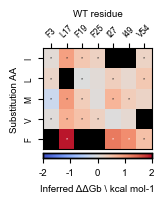

In [32]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':'tight'}
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import numpy as np



firstorderterms['scaled_kcal_mol'] = firstorderterms['mean'] * slope + intercept
firstorderterms['scaled_std'] = firstorderterms['std'] * slope

firstorderterms['mut_from'] = ''
firstorderterms['mut_from'] = firstorderterms['mut_from'].astype('object')
firstorderterms['mut_to'] = ''
firstorderterms['mut_to'] = firstorderterms['mut_to'].astype('object')
firstorderterms['mut_pos'] = 0
firstorderterms['mut_pos'] = firstorderterms['mut_pos'].astype(int)
for index, row in firstorderterms.iterrows():
    firstorderterms.at[index,'mut_from']=row.id_ref[0:-1]
    firstorderterms.at[index,'mut_to']=row.id_ref[-1]
    firstorderterms.at[index,'mut_pos']=int(row.id_ref[1:-1])

mutated_positions = []

for index, row in firstorderterms.iterrows():
    if row.id !='WT' and row.mut_from not in mutated_positions:
        mutated_positions.append(row.mut_from)

firstorderterms=firstorderterms.sort_values(['mut_pos','mut_to'],ascending=[True,True])

coefs_sparse_model = pd.read_csv(path+'Fig7/FYNbDTS_order2_sparseregularized/task_4/weights/weights_Binding.txt',
                       sep='\t')

coefs_sparse_model.rename(columns={'mean_kcal/mol':'mean_kcal_mol', 'std_kcal/mol':'std_kcal_mol', 'ci95_kcal/mol':'ci95_kcal_mol'}, inplace=True)
for index, row in coefs_sparse_model.iterrows():
    if row.id_ref == 'WT':
        coefs_sparse_model.at[index,'order']=0
    else:
        coefs_sparse_model.at[index,'order']=len(row.id.split('_'))
coefs_sparse_model=coefs_sparse_model.set_index('id')

coefs_sparse_model['mut_from'] = ''
coefs_sparse_model['mut_from'] = coefs_sparse_model['mut_from'].astype('object')
coefs_sparse_model['mut_to'] = ''
coefs_sparse_model['mut_to'] = coefs_sparse_model['mut_to'].astype('object')
for index, row in coefs_sparse_model.iterrows():
    coefs_sparse_model.at[index,'mut_from']=row.id_ref[0:-1]
    coefs_sparse_model.at[index,'mut_to']=row.id_ref[-1]
    
coefs_hm_sparse_model = pd.DataFrame(columns=mutated_positions)

for index, row in coefs_sparse_model.iterrows():
    if row.id_ref !='WT' and row.order==1:
        coefs_hm_sparse_model.at[row.mut_to,row.mut_from]='*'
coefs_hm_sparse_model=coefs_hm_sparse_model.fillna('')

real_pos = [2,16,18,24,26,48,53]
mutated_positions = []

for index, row in firstorderterms.iterrows():
    if row.id !='WT' and row.mut_from not in mutated_positions:
        mutated_positions.append(row.mut_from)

coefs_hm=pd.DataFrame(columns=mutated_positions)

for index, row in firstorderterms.iterrows():
    if row.id !='WT':
        coefs_hm.at[row.mut_to,row.mut_from]=row.scaled_kcal_mol

fig, ax = plt.subplots(figsize=(1.4,1.6))

singles_boundary=round(max(firstorderterms.drop_duplicates('scaled_kcal_mol')['scaled_kcal_mol']),0)

#singles_boundary=max(firstorderterms.drop_duplicates('scaled_kcal_mol')['scaled_kcal_mol'])
ax=sns.heatmap(coefs_hm.fillna(0), cmap='coolwarm', vmin=-1*singles_boundary, vmax=singles_boundary,cbar_kws={"orientation": "horizontal", "pad": 0.03, 'location':'bottom'}, xticklabels=True, yticklabels=True,
               annot=coefs_hm_sparse_model.to_numpy().tolist(), fmt= '', annot_kws={'size':4})
ax.figure.axes[-1].set_xticks(ticks=np.arange(-1*round(max(firstorderterms.drop_duplicates('scaled_kcal_mol')['scaled_kcal_mol']),0),round(max(firstorderterms.drop_duplicates('scaled_kcal_mol')['scaled_kcal_mol']),0)+1,1),labels=[int(i) for i in np.arange(-1*round(max(firstorderterms.drop_duplicates('scaled_kcal_mol')['scaled_kcal_mol']),0),round(max(firstorderterms.drop_duplicates('scaled_kcal_mol')['scaled_kcal_mol']),0)+1,1)], fontsize=7)
ax.figure.axes[-1].set_xlabel('Inferred ΔΔGb \ kcal mol-1', rotation=0, labelpad=5, fontsize=7)
plt.tick_params(axis='both', which='both', labelsize=7, labelbottom = False, bottom=False, top = True, labeltop=True)
plt.yticks(fontsize=6)
plt.xticks(fontsize=6, rotation=45)
plt.xlabel('WT residue',  fontsize=7)
ax.xaxis.set_label_position('top') 
plt.ylabel('Substitution AA', fontsize=7)
ax.spines[['right','top','left','bottom']].set_visible(True)
for spine in ax.figure.axes[-1].spines.values():
    spine.set(visible=True,lw=1,edgecolor='black')

for i in mutated_positions:
    for j in mutated_positions:
        if i[0]==j[0]:
            col=coefs_hm.columns.get_loc(i)
            row=coefs_hm.index.get_loc(j[0])
            ax.add_patch(Rectangle((col, row), 1, 1, fill=True,edgecolor='black', lw=0.0001, facecolor='black'))
plt.show()

In [33]:
# Stack the DataFrame
stacked_df = coefs_hm.stack()

# Create a new DataFrame with mutation names as index
mutation_df = stacked_df.rename_axis(index=['AA', 'Position']).reset_index()
mutation_df['Mutation'] = mutation_df['Position'] + mutation_df['AA']
mutation_df = mutation_df.rename(columns={0: 'ddG'}).set_index('Mutation')[['ddG']]
mutation_df.to_csv(path+'FigS24/FYN_binding_ivscaled_ddGs_3state2ndordermodel.txt',sep='\t')

## Panel M

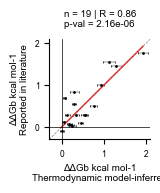

In [34]:
fig, ax = plt.subplots(figsize=(1.3, 1.3))

x = all_core_ddGf_validations[['mean']].to_numpy()
y = all_core_ddGf_validations[['ΔΔGbind (kcal/mol)']].to_numpy()
model = LinearRegression()
model.fit(x, y)
slope = model.coef_[0][0]
intercept = model.intercept_[0]
y_scaled = y
x_scaled = slope * x + intercept
model_scaled = LinearRegression()
model_scaled.fit(x_scaled, y_scaled)
y_pred_scaled = model_scaled.predict(x_scaled)
r, p = pearsonr(y_scaled.ravel(), y_pred_scaled.ravel())
scatter = sns.scatterplot(
    x=x_scaled.ravel(),
    y=y_scaled.ravel(),
    ax=ax,
    s=0,
    edgecolor='k',
    linewidth=0.1,
    color='k'
)
plt.errorbar(
    x_scaled.ravel(), 
    y_scaled.ravel(),
    xerr=all_core_ddGf_validations['std'] * slope, 
    fmt='o',
    elinewidth=0.3, 
    capsize=1, 
    capthick=0.5, 
    markersize=1,
    linewidth=0,
    label='',
    color='k'
)
plt.plot(x_scaled, y_pred_scaled, color='red', linewidth=1, linestyle='-')
ax.axline((0, 0), slope=1, linestyle="dashed", color='gray', lw=0.5)
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)
ax.text(
    0.5, 1.2,
    f'n = {len(x)} | R = {round(r, 2)}\np-val = {p:.2e}',
    fontsize=7, color='black', ha='center', va='center', transform=ax.transAxes
)
plt.xlabel('ΔΔGb kcal mol-1\nThermodynamic model-inferred', fontsize=7)
plt.ylabel('ΔΔGb kcal mol-1\nReported in literature', fontsize=7)
ax.set_xticks(np.arange(0, 4, 1))
ax.set_xticklabels(np.arange(0, 4, 1), fontsize=6)
ax.set_yticks(np.arange(0, 4, 1))
ax.set_yticklabels(np.arange(0, 4, 1), fontsize=6)
ax.spines[['right', 'top']].set_visible(False)
ax.set_ylim(-0.3, 2.1)
ax.set_xlim(-0.3, 2.1)
handles, labels = scatter.get_legend_handles_labels()
palette = {'Dataset1': 'blue', 'Dataset2': 'green'}  # Replace with actual palette if needed
legend_labels = []
custom_markers = [
    Line2D([0], [0], marker='o', markersize=5, linestyle=''),
]
legend = ax.legend(
    handles=custom_markers,
    labels=legend_labels,
    bbox_to_anchor=(0.5, 1.1),
    loc='lower center',
    fontsize=6,
    frameon=False,
    handletextpad=0.5,
    title='',
    title_fontsize=7
)
legend._legend_box.align = "center"
plt.show()

## Panel N

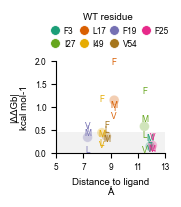

In [35]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':'tight'}

from pylab import *
import matplotlib as mpl
import itertools
mpl.rc('font',family='Arial')

def flip(items, ncol):
    return itertools.chain(*[items[i::ncol] for i in range(ncol)])

dist_core_lig = core_distances['Side chain\nheavy atoms'].to_list()
pos_df = pd.DataFrame({'dist':dist_core_lig}, index=coefs_hm.abs().columns)
pos_dist_asc = pos_df.sort_values(by='dist').index.to_list()

y = coefs_hm.abs().T.to_numpy().flatten()
listoflists = [np.repeat(dist_core_lig[i], 5) for i in range(0,7)]
x = [item for list in listoflists for item in list]

fig, ax = plt.subplots(figsize=(1.4,1.2))
sns.scatterplot(x=x,y=y, hue=np.repeat(coefs_hm.abs().columns, 5), s=50, palette='Dark2')
h, l = ax.get_legend_handles_labels()
plt.close()
fig, ax = plt.subplots(figsize=(1.4,1.2))
ax.axhspan(-1, coefs_hm.abs().mean().mean(), facecolor='gray', alpha=0.1)
sns.scatterplot(x=dist_core_lig,y=coefs_hm.abs().mean(), palette='Dark2',s=50,marker='o', alpha=0.3, hue=list(pos_df.index))

plt.legend(flip(h[0:7],4),flip(l[0:7],4),title = 'WT residue', fontsize=6, title_fontsize=7, frameon=False, ncol=(len(pos_df.index)+1)/2, columnspacing=0, handletextpad=0,bbox_to_anchor=(1.1,1.6))
plt.xlabel('Distance to ligand\nÅ', fontsize=7)
plt.ylabel('|ΔΔGb|'+ '\n'+ 'kcal mol-1', fontsize=7)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

ax.set_xticks(np.arange(5,15,2))
ax.set_yticks(np.arange(0,2.5,0.5))
ax.set_ylim(0,2)
ax.spines[['top','right']].set_visible(False)

def label_point(x, y, val, ax, colors):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    col = a.iloc[0]['x']
    counter=0
    for i, point in a.iterrows():
        if point['x'] != col:
            col=point['x']
            counter+=1
        ax.text(point['x'], point['y'], str(point['val']), fontsize=6, color=colors[counter], ha='center')

colors=list(sns.color_palette('Dark2',len(pos_df)))


label_point(pd.Series(x).loc[pd.Series(y).notnull()], pd.Series(y).loc[pd.Series(y).notnull()], pd.Series(np.tile(coefs_hm.abs().index, 7)).loc[pd.Series(y).notnull()], plt.gca(), colors)

plt.show()